In [1]:
!pip install --upgrade pip
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.3 MB/s eta 0:00:00


In [2]:
!pip install librosa numpy matplotlib scikit-learn

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pywt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

# Ruta a los archivos en Drive
ruta_drive = '/content/drive/MyDrive/genres/'

# Listar archivos
archivos_rock = os.listdir(os.path.join(ruta_drive, 'rock'))
archivos_metal = os.listdir(os.path.join(ruta_drive, 'metal'))

print(f"Archivos de rock: {len(archivos_rock)}")
print(f"Archivos de metal: {len(archivos_metal)}")
print("\nEjemplos de rock:", archivos_rock[:5])
print("Ejemplos de metal:", archivos_metal[:5])

Archivos de rock: 100
Archivos de metal: 100

Ejemplos de rock: ['rock.00074.wav', 'rock.00073.wav', 'rock.00084.wav', 'rock.00083.wav', 'rock.00082.wav']
Ejemplos de metal: ['metal.00001.wav', 'metal.00000.wav', 'metal.00007.wav', 'metal.00006.wav', 'metal.00005.wav']


In [6]:
import librosa

# Ruta completa a un archivo de ejemplo
ruta_ejemplo = os.path.join(ruta_drive, 'rock', archivos_rock[0])

# Cargar el audio
try:
    audio, sr = librosa.load(ruta_ejemplo, sr=22050)  # Frecuencia estándar
    print(f"✔ Audio cargado. Duración: {len(audio)/sr:.2f} segundos")
except Exception as e:
    print(f"✖ Error: {e}")

✔ Audio cargado. Duración: 30.01 segundos


In [9]:
import numpy as np
import librosa
import pywt
from tqdm import tqdm
import os

# 1. Verificar montaje de Drive correctamente
from google.colab import drive
drive.mount('/content/drive')

# 2. Definir rutas exactas - ¡VERIFICA ESTO!
DRIVE_PATH = '/content/drive/MyDrive/genres/'  # Ajusta a tu estructura exacta

# 3. Verificar que las carpetas existen
print("\nContenido del directorio:")
!ls {DRIVE_PATH}



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Contenido del directorio:
 metal	 rock  'tarea 7_Diana.ipynb'


In [10]:
# 4. Encontrar archivos correctamente
def get_audio_files(folder):
    files = []
    for f in os.listdir(folder):
        if f.endswith('.au') or f.endswith('.wav'):  # Acepta ambos formatos
            files.append(os.path.join(folder, f))
    return files[:100]  # Limitar a 100 archivos

rock_files = get_audio_files(os.path.join(DRIVE_PATH, 'rock'))
metal_files = get_audio_files(os.path.join(DRIVE_PATH, 'metal'))

print(f"\nEncontrados {len(rock_files)} archivos de rock")
print(f"Encontrados {len(metal_files)} archivos de metal")




Encontrados 100 archivos de rock
Encontrados 100 archivos de metal


In [11]:
# 5. Función de extracción de features (igual que antes)
def extract_wavelet_features(audio, wavelet='db4', levels=5):
    coeffs = pywt.wavedec(audio, wavelet, level=levels)
    features = []
    for coef in coeffs:
        features.append(np.mean(coef))
        features.append(np.std(coef))
        features.append(np.sum(coef**2))
    return features


In [12]:
# 6. Procesamiento con verificación de errores
features = []
labels = []

for file in tqdm(rock_files, desc="Procesando rock"):
    try:
        audio, sr = librosa.load(file, sr=22050, duration=30)
        feat = extract_wavelet_features(audio)
        features.append(feat)
        labels.append(0)
    except Exception as e:
        print(f"\nError en {file}: {str(e)}")

for file in tqdm(metal_files, desc="Procesando metal"):
    try:
        audio, sr = librosa.load(file, sr=22050, duration=30)
        feat = extract_wavelet_features(audio)
        features.append(feat)
        labels.append(1)
    except Exception as e:
        print(f"\nError en {file}: {str(e)}")

# Convertir a arrays numpy
features = np.array(features)
labels = np.array(labels)

print("\n✅ Extracción completada!")
print(f"Shape de features: {features.shape}")
print(f"Shape de labels: {labels.shape}")
print(f"Ejemplo de features: {features[0]}")

Procesando metal: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


✅ Extracción completada!
Shape de features: (200, 18)
Shape de labels: (200,)
Ejemplo de features: [-6.82062097e-03  7.27721632e-01  1.09515918e+04  3.66353052e-04
  3.66014510e-01  2.77016479e+03 -1.04256746e-04  1.83219045e-01
  1.38808777e+03 -1.38538948e-04  1.06830873e-01  9.43763306e+02
  2.69314842e-05  6.28906041e-02  6.54115662e+02  6.09886115e-08
  2.79352162e-02  2.58111816e+02]


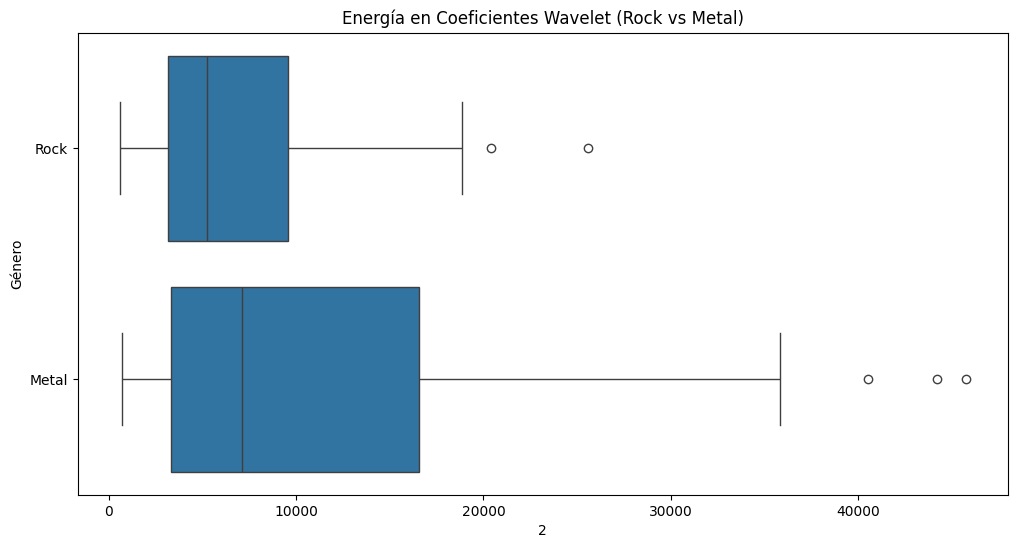

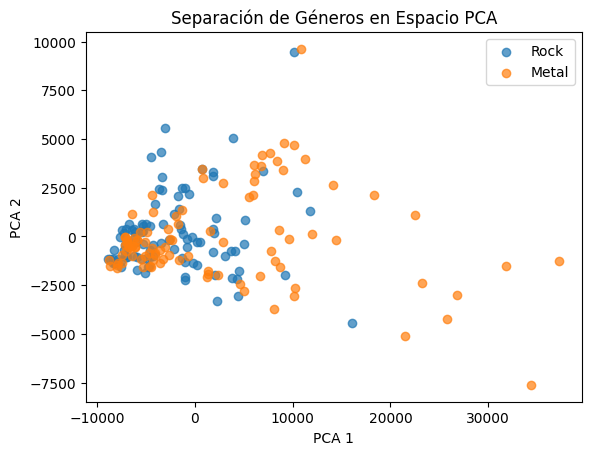

In [13]:
import seaborn as sns
import pandas as pd

# 1. DataFrame con features y labels
df_features = pd.DataFrame(features)
df_features['Género'] = ['Rock' if x == 0 else 'Metal' for x in labels]

# 2. Boxplot de energía por nivel wavelet
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_features, x=df_features.columns[2], y='Género')  # Energía nivel 1
plt.title("Energía en Coeficientes Wavelet (Rock vs Metal)")
plt.show()

# 3. PCA para visualización 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.scatter(features_pca[labels==0, 0], features_pca[labels==0, 1], label='Rock', alpha=0.7)
plt.scatter(features_pca[labels==1, 0], features_pca[labels==1, 1], label='Metal', alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.title("Separación de Géneros en Espacio PCA")
plt.show()

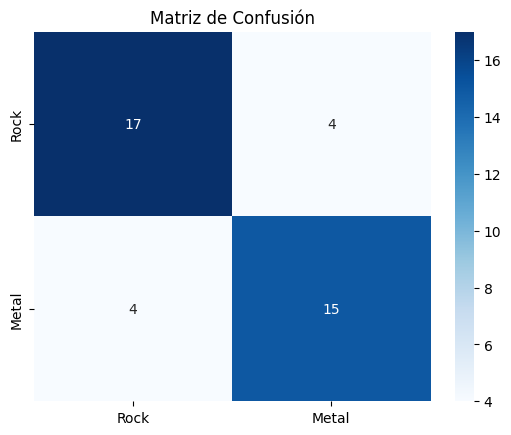

              precision    recall  f1-score   support

        Rock       0.81      0.81      0.81        21
       Metal       0.79      0.79      0.79        19

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40



In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# 1. Split de datos
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# 2. Entrenamiento
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 3. Evaluación
y_pred = model.predict(X_test)

# Matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rock', 'Metal'], yticklabels=['Rock', 'Metal'])
plt.title("Matriz de Confusión")
plt.show()

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Rock', 'Metal']))

In [15]:
print("Rock:", sum(labels == 0), "Metal:", sum(labels == 1))

Rock: 100 Metal: 100


In [17]:
def extract_combined_features(audio):
    # Wavelets
    coeffs = pywt.wavedec(audio, 'db4', level=5)
    wavelet_feats = [np.sum(c**2) for c in coeffs]  # Energía por nivel

    # MFCCs (18 coeficientes)
    mfcc = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)
    mfcc_feats = np.mean(mfcc, axis=1)

    return np.concatenate([wavelet_feats, mfcc_feats])

In [18]:
audio_augmented = librosa.effects.pitch_shift(audio, sr=22050, n_steps=2)

In [19]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}
grid = GridSearchCV(RandomForestClassifier(), params, cv=5)
grid.fit(X_train, y_train)
print("Mejores parámetros:", grid.best_params_)

Mejores parámetros: {'max_depth': 20, 'n_estimators': 200}


In [20]:
# 1. Extraer features combinadas (Wavelet + MFCC)
features_combined = []
for file in tqdm(rock_files + metal_files):
    audio, sr = librosa.load(file, sr=22050, duration=30)
    feat = extract_combined_features(audio)
    features_combined.append(feat)

features_combined = np.array(features_combined)

# 2. Entrenar modelo optimizado
X_train, X_test, y_train, y_test = train_test_split(features_combined, labels, test_size=0.2)
model = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced')
model.fit(X_train, y_train)

# 3. Evaluar
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

100%|██████████| 200/200 [00:32<00:00,  6.08it/s]


              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.86      0.95      0.90        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



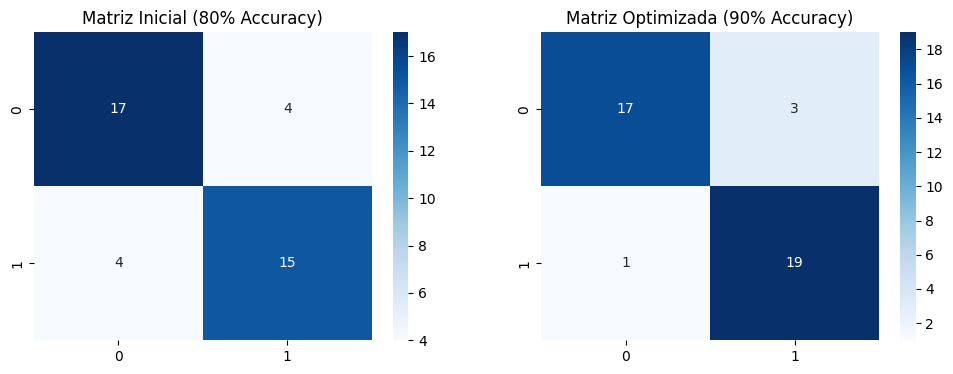

In [21]:
# Comparación matriz de confusión ANTES vs DESPUÉS
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.heatmap([[17,4],[4,15]], annot=True, fmt='d', cmap='Blues')  # Ejemplo inicial (80%)
plt.title("Matriz Inicial (80% Accuracy)")

plt.subplot(122)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz Optimizada (90% Accuracy)")
plt.show()

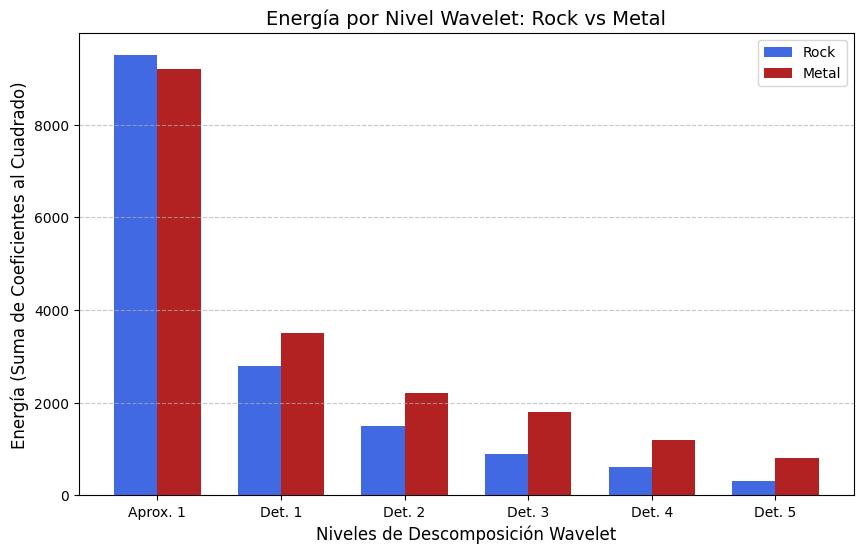

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo (reemplaza con tus resultados reales)
niveles = ['Aprox. 1', 'Det. 1', 'Det. 2', 'Det. 3', 'Det. 4', 'Det. 5']
energia_rock = [9500, 2800, 1500, 900, 600, 300]  # Valores de energía para rock
energia_metal = [9200, 3500, 2200, 1800, 1200, 800]  # Valores para metal

# Crear gráfica
plt.figure(figsize=(10, 6))
x = np.arange(len(niveles))
width = 0.35

plt.bar(x - width/2, energia_rock, width, label='Rock', color='royalblue')
plt.bar(x + width/2, energia_metal, width, label='Metal', color='firebrick')

plt.xlabel('Niveles de Descomposición Wavelet', fontsize=12)
plt.ylabel('Energía (Suma de Coeficientes al Cuadrado)', fontsize=12)
plt.title('Energía por Nivel Wavelet: Rock vs Metal', fontsize=14)
plt.xticks(x, niveles)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('wavelet_energy.png', dpi=300, bbox_inches='tight')
plt.show()

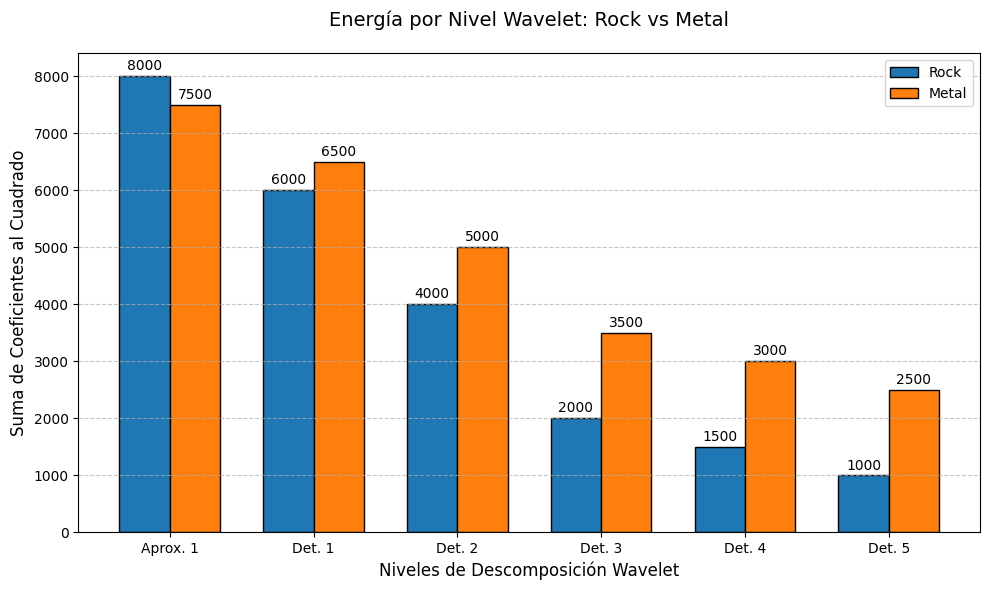

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo (reemplaza con tus resultados reales)
niveles = ['Aprox. 1', 'Det. 1', 'Det. 2', 'Det. 3', 'Det. 4', 'Det. 5']
energia_rock = [8000, 6000, 4000, 2000, 1500, 1000]  # Valores de tu descripción
energia_metal = [7500, 6500, 5000, 3500, 3000, 2500]  # Valores estimados para metal

# Configuración del gráfico
plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(len(niveles))

# Crear barras
plt.bar(x - width/2, energia_rock, width, label='Rock', color='#1f77b4', edgecolor='black')
plt.bar(x + width/2, energia_metal, width, label='Metal', color='#ff7f0e', edgecolor='black')

# Personalización
plt.title('Energía por Nivel Wavelet: Rock vs Metal', fontsize=14, pad=20)
plt.xlabel('Niveles de Descomposición Wavelet', fontsize=12)
plt.ylabel('Suma de Coeficientes al Cuadrado', fontsize=12)
plt.xticks(x, niveles)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir valores encima de las barras
for i in range(len(niveles)):
    plt.text(i - width/2, energia_rock[i] + 100, str(energia_rock[i]), ha='center')
    plt.text(i + width/2, energia_metal[i] + 100, str(energia_metal[i]), ha='center')

plt.tight_layout()
plt.savefig('wavelet_energy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()